<a href="https://colab.research.google.com/github/OctavioGuaschi/IA901-2023S1/blob/main/projetos/Human_physical_position_detection/notebooks/Detec%C3%A7%C3%A3o_de_posi%C3%A7%C3%A3o_f%C3%ADsica_humana%5Bdeprecated%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Octavio S Guaschi, 218390

---


Breno Portela, 253502

---


Cesar Bastos, 264521

---



Notebook de implementação de detecção de posição física humana

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = "gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_dataset(OpenCV)"
#/content/gdrive/MyDrive/Classroom/P_IA901A_2023S1/Projeto

Mounted at /content/gdrive


In [ ]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

# Neptune Config

In [ ]:
! pip install neptune-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.2/448.2 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 120.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.5 MB/s eta 0:00:00


In [ ]:
import neptune.new as neptune
from neptune.types import File


def neptune_start(name='Default'):
    run = neptune.init_run (project= 'octavioguaschi/IA901-218390',#"breno/IA901-2023S1",#
                       name=name,
                       #custom_run_id=name,
                      # tags=[model.name,'Segmento1', 'tags', 'vocab_size_2000', 'as-list-of-strings'],
                      #api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5MmNmOWUxNC1iOGYyLTQ1NjEtOWI4Mi04MTRlOTUwMTgxMzcifQ==")
                       api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTM4ZmY5My1iMzE5LTQ0MzQtOTA5MS02MzUzZTkxYTI0OGIifQ==")
    return run



/usr/local/lib/python3.10/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-4-8d277147f7f8>:1: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


# Dataset Loader


In [ ]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [ ]:
# Data augmentation and normalization for training

data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize((170,170)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        #transforms.Resize((170,170)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        #transforms.Resize((170,170)),
        transforms.ToTensor()
    ])
}

image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}

# Train 143 (56,5%), Val 62 (24,5%), Test 48 (19%)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
print(dataset_sizes)

{'train': 2890, 'val': 964, 'test': 963}


Batch of training data


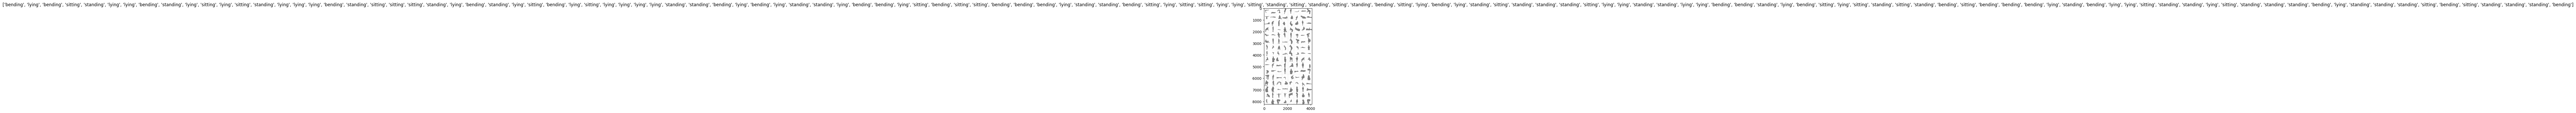

Batch of validation data


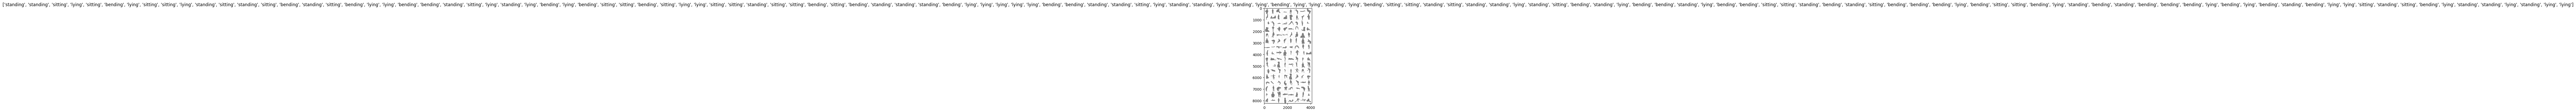

Batch of test data


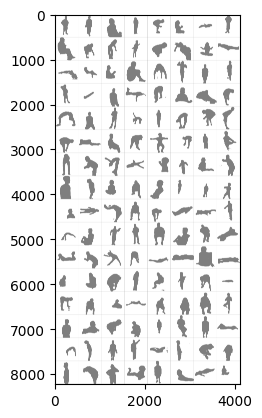

('gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_dataset(OpenCV)/test/standing/387.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_dataset(OpenCV)/test/standing/353.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_dataset(OpenCV)/test/sitting/462.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_dataset(OpenCV)/test/standing/585.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_dataset(OpenCV)/test/bending/300.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_dataset(OpenCV)/test/sitting/620.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_dataset(OpenCV)/test/lying/511 (1).jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_dataset(OpenCV)/test/standing/381.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_dataset(OpenCV)/test/sitting/942.jpg', 'gdrive/MyDrive/Projeto/data/raw/Human_silhouettes_splited_dataset(OpenCV)/test/bending/843.jpg', 'gdrive/MyDri

In [ ]:
#visualize
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes, _ = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


print('Batch of validation data')
inputs, classes, _ = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



print('Batch of test data')
inputs, _, paths = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

print(paths)

# Função do treinamento com Neptune

In [ ]:
def train_model_Neptune(model, criterion, optimizer, scheduler,neptune, num_epochs=25):
    since = time.time()
    run = neptune
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    PARAMS = {'model': model,
              'nb_epoch': num_epochs,
              'criterion': 'Cross',
              'optimizer': optimizer.defaults,
              #'gradient_accumulation_steps': self.gradient_accumulation_steps,
              #'best_valid_loss': best_valid_loss,
              #'hparams': hparams
        }
    run['PARAMS'] = PARAMS


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, _ in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                run['train/epoch_loss'].append(epoch_loss)
                run['train/epoch_acc'].append(epoch_acc)
            if phase == 'val':
                run['val/epoch_loss'].append(epoch_loss)
                run['val/epoch_acc'].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

   # run["score"] = 0.97
    run["acc"] = best_acc
    run["time_elapsed"] = time_elapsed
    # load best model weights
    model.load_state_dict(best_model_wts)
    run["model/pickled_model"].upload(File.as_pickle(model))
    return model


In [ ]:

certos = 0
errados = 0
def test_model(model, num_images=48):
    was_training = model.training
    model.eval()
    images_so_far = 0
    certos = 0
    errados = 0

    with torch.no_grad():
        for i, (inputs, _, paths) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if(paths[j].split('/')[7] != class_names[preds[j]]):
                  images_so_far += 1
                  errados += 1
                  fig = plt.figure(figsize=(50, 50))
                  plt.tight_layout()
                  plt.subplot(num_images, 1, images_so_far)
                  plt.axis('off')
                  print('path: {} / predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                  run['test/predicted'].append('path: {} / predicted: {}'.format(paths[j].split('/')[7], class_names[preds[j]]))
                  imshow(inputs.cpu().data[j])
                else:
                  certos +=1
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    print('Test Acc: {:4f}'.format(certos/(certos+errados)))
                    run['test/acc'].append(certos/(certos+errados))
                    return
        model.train(mode=was_training)

# Modelos

In [ ]:
#@title Alexnet

model_alex = models.alexnet(pretrained = True)
num_ftrs_alex = model_alex.classifier[6].in_features
model_alex.classifier[6] = nn.Linear(num_ftrs_alex, len(class_names))
model_alex = model_alex.to(device)
optimizer_alex = optim.SGD(model_alex.parameters(), lr=0.0007, momentum=0.9)
exp_lr_scheduler_alex = lr_scheduler.StepLR(optimizer_alex, step_size=200, gamma=0.5)

summary(model_alex, (3, 512, 512))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 80.0MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 127, 127]          23,296
              ReLU-2         [-1, 64, 127, 127]               0
         MaxPool2d-3           [-1, 64, 63, 63]               0
            Conv2d-4          [-1, 192, 63, 63]         307,392
              ReLU-5          [-1, 192, 63, 63]               0
         MaxPool2d-6          [-1, 192, 31, 31]               0
            Conv2d-7          [-1, 384, 31, 31]         663,936
              ReLU-8          [-1, 384, 31, 31]               0
            Conv2d-9          [-1, 256, 31, 31]         884,992
             ReLU-10          [-1, 256, 31, 31]               0
           Conv2d-11          [-1, 256, 31, 31]         590,080
             ReLU-12          [-1, 256, 31, 31]               0
        MaxPool2d-13          [-1, 256, 15, 15]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
#@title Efficientnet

model_efficient = models.efficientnet_b0(pretrained = True)
num_ftrs_efficient = model_efficient.classifier[1].in_features
model_efficient.classifier[1] = nn.Linear(num_ftrs_efficient, len(class_names))
model_efficient = model_efficient.to(device)
optimizer_efficient = optim.SGD(model_efficient.parameters(), lr=0.0006, momentum=0.9)
exp_lr_scheduler_efficient = lr_scheduler.StepLR(optimizer_efficient, step_size=200, gamma=0.5)

summary(model_efficient, (3, 512, 512))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 27.6MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              SiLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              SiLU-6         [-1, 32, 256, 256]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 256, 256]               0
           Conv2d-13         [-1, 16, 256, 256]             512
      BatchNorm2d-14         [-1, 16, 2

In [ ]:
#@title Efficientnet_V2

model_efficientV2 = models.efficientnet_v2_s(pretrained = True)
num_ftrs_efficientV2 = model_efficientV2.classifier[1].in_features
model_efficientV2.classifier[1] = nn.Linear(num_ftrs_efficientV2, len(class_names))
model_efficientV2 = model_efficientV2.to(device)
optimizer_efficientV2 = optim.SGD(model_efficientV2.parameters(), lr=0.0009, momentum=0.9)
exp_lr_scheduler_efficientV2 = lr_scheduler.StepLR(optimizer_efficientV2, step_size=200, gamma=0.5)

summary(model_efficientV2, (3, 512, 512))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:05<00:00, 15.7MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 256, 256]             648
       BatchNorm2d-2         [-1, 24, 256, 256]              48
              SiLU-3         [-1, 24, 256, 256]               0
            Conv2d-4         [-1, 24, 256, 256]           5,184
       BatchNorm2d-5         [-1, 24, 256, 256]              48
              SiLU-6         [-1, 24, 256, 256]               0
   StochasticDepth-7         [-1, 24, 256, 256]               0
       FusedMBConv-8         [-1, 24, 256, 256]               0
            Conv2d-9         [-1, 24, 256, 256]           5,184
      BatchNorm2d-10         [-1, 24, 256, 256]              48
             SiLU-11         [-1, 24, 256, 256]               0
  StochasticDepth-12         [-1, 24, 256, 256]               0
      FusedMBConv-13         [-1, 24, 256, 256]               0
           Conv2d-14         [-1, 96, 1

In [ ]:
#@title Googlenet

model_googlenet = models.googlenet(pretrained = True)
num_ftrs_googlenet = model_googlenet.fc.in_features
model_googlenet.fc = nn.Linear(num_ftrs_googlenet, len(class_names))
model_googlenet = model_googlenet.to(device)
optimizer_googlenet = optim.SGD(model_googlenet.parameters(), lr=0.0004, momentum=0.9)
exp_lr_scheduler_googlenet = lr_scheduler.StepLR(optimizer_googlenet, step_size=200, gamma=0.5)

summary(model_googlenet, (3, 512, 512))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:15<00:00, 3.42MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
       BasicConv2d-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
       BasicConv2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 192, 128, 128]         110,592
       BatchNorm2d-9        [-1, 192, 128, 128]             384
      BasicConv2d-10        [-1, 192, 128, 128]               0
        MaxPool2d-11          [-1, 192, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          12,288
      BatchNorm2d-13           [-1, 64, 64, 64]             128
      BasicConv2d-14           [-1, 64,

In [ ]:
#@title Resnet18

model_res18 = models.resnet18(pretrained=True)
num_ftrs_res18 = model_res18.fc.in_features
model_res18.fc = nn.Linear(num_ftrs_res18, len(class_names))
model_res18 = model_res18.to(device)
optimizer_res18 = optim.SGD(model_res18.parameters(), lr=0.0003, momentum=0.9)
exp_lr_scheduler_res18 = lr_scheduler.StepLR(optimizer_res18, step_size=200, gamma=0.5)

summary(model_res18, (3, 512, 512))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 289MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,864
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
       BasicBlock-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,864
      BatchNorm2d-13         [-1, 64, 128, 128]             128
             ReLU-14         [-1, 64, 1

In [ ]:
#@title VGG19

model_vgg19 = models.vgg19(pretrained=True)
num_ftrs_vgg19 = model_vgg19.classifier[6].in_features
model_vgg19.classifier[6] = nn.Linear(num_ftrs_vgg19, len(class_names))
model_vgg19 = model_vgg19.to(device)
optimizer_vgg19 = optim.SGD(model_vgg19.parameters(), lr=0.0003, momentum=0.9)
exp_lr_scheduler_vgg19 = lr_scheduler.StepLR(optimizer_vgg19, step_size=200, gamma=0.5)

summary(model_vgg19, (3, 512, 512))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 52.9MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

In [ ]:
nn_models = [model_alex, model_efficient, model_efficientV2, model_googlenet, model_res18, model_vgg19]
models_name = ['model_alex', 'model_efficient', 'model_efficientV2', 'model_googlenet', 'model_res18', 'model_vgg19']
optimizer = [optimizer_alex, optimizer_efficient, optimizer_efficientV2, optimizer_googlenet, optimizer_res18, optimizer_vgg19]
exp_lr_scheduler = [exp_lr_scheduler_alex, exp_lr_scheduler_efficient, exp_lr_scheduler_efficientV2, exp_lr_scheduler_googlenet, exp_lr_scheduler_res18, exp_lr_scheduler_vgg19]
num_epochs = [20, 20, 20, 20, 20, 20]
criterion = nn.CrossEntropyLoss()
test_acc = np.zeros(6)

# Treinamento e Teste das Redes

## Alexnet

In [ ]:
#@title Treinamento

run = neptune_start(models_name[0])
nn_models[0] = train_model_Neptune(nn_models[0], criterion, optimizer[0],
                                           exp_lr_scheduler[0], run, num_epochs[0])
run.stop()

<ipython-input-4-8d277147f7f8>:6: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run (project= 'octavioguaschi/IA901-218390',#"breno/IA901-2023S1",#


https://app.neptune.ai/octavioguaschi/IA901-218390/e/IA90-102
Epoch 0/19
----------


<ipython-input-9-14b1b7e0ec1e>:14: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'torchvision.models.alexnet.AlexNet'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run['PARAMS'] = PARAMS
<ipython-input-9-14b1b7e0ec1e>:14: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'NoneType'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run['PARAMS'] = PARAMS


train Loss: 1.0326 Acc: 0.5990
val Loss: 0.6668 Acc: 0.8039

Epoch 1/19
----------
train Loss: 0.6320 Acc: 0.7827
val Loss: 0.5511 Acc: 0.8195

Epoch 2/19
----------
train Loss: 0.5388 Acc: 0.8125
val Loss: 0.4537 Acc: 0.8485

Epoch 3/19
----------
train Loss: 0.4655 Acc: 0.8332
val Loss: 0.4017 Acc: 0.8683

Epoch 4/19
----------
train Loss: 0.4154 Acc: 0.8516
val Loss: 0.3655 Acc: 0.8807

Epoch 5/19
----------
train Loss: 0.3839 Acc: 0.8651
val Loss: 0.3443 Acc: 0.8838

Epoch 6/19
----------
train Loss: 0.3636 Acc: 0.8716
val Loss: 0.3383 Acc: 0.8900

Epoch 7/19
----------
train Loss: 0.3491 Acc: 0.8709
val Loss: 0.3154 Acc: 0.8890

Epoch 8/19
----------
train Loss: 0.3195 Acc: 0.8862
val Loss: 0.3013 Acc: 0.9056

Epoch 9/19
----------
train Loss: 0.3050 Acc: 0.8934
val Loss: 0.3089 Acc: 0.8932

Epoch 10/19
----------
train Loss: 0.3049 Acc: 0.8907
val Loss: 0.2969 Acc: 0.8994

Epoch 11/19
----------
train Loss: 0.2690 Acc: 0.9010
val Loss: 0.2900 Acc: 0.9025

Epoch 12/19
----------
t

In [ ]:
#@title Teste

#print(models_name[0])
#test_model(nn_models[0])
torch.cuda.empty_cache()

## Efficientnet

In [ ]:
#@title Treinamento

run = neptune_start(models_name[1])
nn_models[1] = train_model_Neptune(nn_models[1], criterion, optimizer[1],
                                           exp_lr_scheduler[1], run, num_epochs[1])
run.stop()

https://app.neptune.ai/octavioguaschi/IA901-218390/e/IA90-103
Epoch 0/19
----------


<ipython-input-9-14b1b7e0ec1e>:14: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'torchvision.models.efficientnet.EfficientNet'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run['PARAMS'] = PARAMS


OutOfMemoryError: ignored

In [ ]:
#@title Teste

#print(models_name[1])
#test_model(nn_models[1])
torch.cuda.empty_cache()

## Efficientnet_V2

In [ ]:
#@title Treinamento

run = neptune_start(models_name[2])
nn_models[2] = train_model_Neptune(nn_models[2], criterion, optimizer[2],
                                           exp_lr_scheduler[2], run, num_epochs[2])
run.stop()

In [ ]:
#@title Teste

#print(models_name[2])
#test_model(nn_models[2])
torch.cuda.empty_cache()

## Googlenet

In [ ]:
#@title Treinamento

run = neptune_start(models_name[3])
nn_models[3] = train_model_Neptune(nn_models[3], criterion, optimizer[3],
                                           exp_lr_scheduler[3], run, num_epochs[3])
run.stop()

In [ ]:
#@title Teste

#print(models_name[3])
#test_model(nn_models[3])
torch.cuda.empty_cache()

## Resnet18

In [ ]:
#@title Treinamento

run = neptune_start(models_name[4])
nn_models[4] = train_model_Neptune(nn_models[4], criterion, optimizer[4],
                                           exp_lr_scheduler[4], run, num_epochs[4])
run.stop()

In [ ]:
#@title Teste

#print(models_name[4])
#test_model(nn_models[4])
torch.cuda.empty_cache()

## VGG19

In [ ]:
#@title Treinamento

run = neptune_start(models_name[5])
nn_models[5] = train_model_Neptune(nn_models[5], criterion, optimizer[5],
                                           exp_lr_scheduler[5], run, num_epochs[5])
run.stop()

In [ ]:
#@title Teste

#print(models_name[5])
#test_model(nn_models[5])
torch.cuda.empty_cache()